# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import os

%load_ext tensorboard

# to make this notebook's output stable across runs
np.random.seed(55)

# To plot pretty figures
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Exercise

In [2]:
K.clear_session()
np.random.seed(55)
tf.random.set_seed(55)

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 1759s 10us/step


In [4]:
X_train_full.shape

(50000, 32, 32, 3)

In [5]:
y_train_full.shape

(50000, 1)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [7]:
y_test.shape

(10000, 1)

In [8]:
X_train, X_valid = X_train_full[:45000]/255., X_train_full[45000:]/255.
y_train, y_valid = y_train_full[:45000], y_train_full[45000:]
X_test = X_test/255.

In [9]:
model = Sequential()

model.add(Flatten(input_shape = (32, 32, 3)))
for i in range(20):
    model.add(Dense(100, activation="elu", 
                    kernel_initializer="he_normal"))
model.add(Dense(10, activation="softmax"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [11]:
optimizer = keras.optimizers.Nadam(lr=1e-5)

model.compile(loss='sparse_categorical_crossentropy', 
             optimizer=optimizer, 
             metrics=['accuracy'])

In [12]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.losses = []
        self.rates = []
    def on_batch_end(self, batch, logs):
        self.losses.append(logs["loss"])
        self.rates.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [13]:
exp_cb = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[exp_cb])

1407/1407 [==============================] - 16s 11ms/step - loss: 18330.7930 - accuracy: 0.1970 - val_loss: 5.2354 - val_accuracy: 0.1058


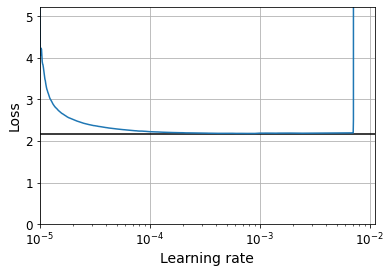

In [14]:
plt.plot(exp_cb.rates, exp_cb.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exp_cb.losses), min(exp_cb.rates), max(exp_cb.rates))
plt.axis([min(exp_cb.rates), max(exp_cb.rates), 0, exp_cb.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.grid(True)

In [15]:
K.clear_session()
np.random.seed(55)
tf.random.set_seed(55)

In [16]:
model = Sequential()

model.add(Flatten(input_shape = (32, 32, 3)))
for i in range(20):
    model.add(Dense(100, activation="elu", 
                    kernel_initializer="he_normal"))
model.add(Dense(10, activation="softmax"))

In [17]:
optimizer = keras.optimizers.Nadam(lr=3e-5)

model.compile(loss='sparse_categorical_crossentropy', 
             optimizer=optimizer, 
             metrics=['accuracy'])

In [18]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)

run_index = 1
run_logdir = f"{os.curdir}/my_cifar10_logs/run_{run_index}"
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [9]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [21]:
history = model.fit(X_train, y_train, epochs=1000, 
          validation_data=(X_valid, y_valid), 
          callbacks=callbacks)

Epoch 1/1000
1407/1407 [==============================] - 16s 11ms/step - loss: 1.9497 - accuracy: 0.2897 - val_loss: 1.7900 - val_accuracy: 0.3560
Epoch 2/1000
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7458 - accuracy: 0.3694 - val_loss: 1.8663 - val_accuracy: 0.3278
Epoch 3/1000
1407/1407 [==============================] - 16s 12ms/step - loss: 1.6632 - accuracy: 0.4022 - val_loss: 1.7229 - val_accuracy: 0.3862
Epoch 4/1000
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6064 - accuracy: 0.4209 - val_loss: 1.7599 - val_accuracy: 0.3708
Epoch 5/1000
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5632 - accuracy: 0.4380 - val_loss: 1.5868 - val_accuracy: 0.4306
Epoch 6/1000
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5331 - accuracy: 0.4504 - val_loss: 1.5853 - val_accuracy: 0.4292
Epoch 7/1000
1407/1407 [==============================] - 15s 11ms/step - loss: 1.5027 - accuracy: 0.4616 - val_

In [22]:
model = keras.models.load_model("my_cifar10_model.h5")

In [23]:
model.evaluate(X_train, y_train)

1407/1407 [==============================] - 4s 3ms/step - loss: 1.1164 - accuracy: 0.6034


[1.1164263486862183, 0.6033555269241333]

In [24]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 1.4034 - accuracy: 0.5102


[1.4033551216125488, 0.510200023651123]

In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4362 - accuracy: 0.5023


[1.436204433441162, 0.5023000240325928]

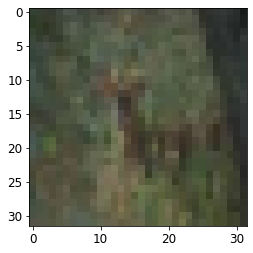

In [26]:
plt.imshow(X_train[10])

In [27]:
y_train[10]

array([4], dtype=uint8)

In [44]:
K.clear_session()
np.random.seed(55)
tf.random.set_seed(55)

In [45]:
model = Sequential()

model.add(Flatten(input_shape = (32, 32, 3)))
model.add(BatchNormalization())

for _ in range(20):
    model.add(Dense(100, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    
model.add(Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr = 3e-4)
model.compile(loss='sparse_categorical_crossentropy', 
             optimizer=optimizer, 
             metrics=['accuracy'])

In [46]:
exp_cb = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[exp_cb])

1407/1407 [==============================] - 24s 17ms/step - loss: 7.1998 - accuracy: 0.2454 - val_loss: 1466.3466 - val_accuracy: 0.1030


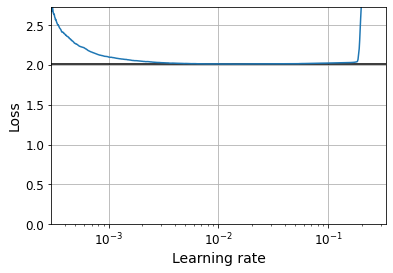

In [47]:
plt.plot(exp_cb.rates, exp_cb.losses)
plt.gca().set_xscale('log')
plt.hlines(min(exp_cb.losses), min(exp_cb.rates), max(exp_cb.rates))
plt.axis([min(exp_cb.rates), max(exp_cb.rates), 0, exp_cb.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.grid(True)

In [12]:
rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 3e-4, 7.5e-4]

for i in range(len(rates)):
    K.clear_session()
    np.random.seed(55)
    tf.random.set_seed(55)

    model = Sequential()

    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(BatchNormalization())

    for _ in range(20):
        model.add(Dense(100, kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))

    model.add(Dense(10, activation="softmax"))

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    model_checkpoint_cb = keras.callbacks.ModelCheckpoint(f"my_cifar10_bn_model_{i+1}.h5", save_best_only=True)

    run_logdir = f"{os.curdir}/my_cifar10_logs/run_bn_{i+1}"
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

    callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

    optimizer=keras.optimizers.Nadam(lr = rates[i])

    model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer=optimizer, 
                 metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=20, 
              validation_data=(X_valid, y_valid), 
              callbacks=callbacks)


Epoch 1/20
1407/1407 [==============================] - 25s 18ms/step - loss: 1.8410 - accuracy: 0.3403 - val_loss: 1.7121 - val_accuracy: 0.3862
Epoch 2/20
1407/1407 [==============================] - 23s 17ms/step - loss: 1.6821 - accuracy: 0.4022 - val_loss: 1.6250 - val_accuracy: 0.4208
Epoch 3/20
1407/1407 [==============================] - 25s 18ms/step - loss: 1.6119 - accuracy: 0.4258 - val_loss: 1.5427 - val_accuracy: 0.4432
Epoch 4/20
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5644 - accuracy: 0.4427 - val_loss: 1.4708 - val_accuracy: 0.4760
Epoch 5/20
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5167 - accuracy: 0.4608 - val_loss: 1.4366 - val_accuracy: 0.4972
Epoch 6/20
1407/1407 [==============================] - 23s 16ms/step - loss: 1.4800 - accuracy: 0.4743 - val_loss: 1.4237 - val_accuracy: 0.4920
Epoch 7/20
1407/1407 [==============================] - 25s 18ms/step - loss: 1.4467 - accuracy: 0.4869 - val_loss: 1.4157 -

In [54]:
K.clear_session()
np.random.seed(55)
tf.random.set_seed(55)

model = Sequential()

model.add(Flatten(input_shape=(32, 32, 3)))
model.add(BatchNormalization())

for _ in range(20):
    model.add(Dense(100, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

model.add(Dense(10, activation="softmax"))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(f"my_cifar10_bn_model.h5", save_best_only=True)

callbacks = [early_stopping_cb, model_checkpoint_cb]

optimizer = keras.optimizers.Nadam(lr=1.5e-3)

model.compile(loss='sparse_categorical_crossentropy', 
             optimizer=optimizer, 
             metrics=['accuracy'])



In [55]:
history = model.fit(X_train, y_train, epochs=1000, 
          validation_data=(X_valid, y_valid), 
          callbacks=callbacks)

Epoch 1/1000
1407/1407 [==============================] - 22s 16ms/step - loss: 1.8508 - accuracy: 0.3383 - val_loss: 1.7908 - val_accuracy: 0.3738
Epoch 2/1000
1407/1407 [==============================] - 23s 16ms/step - loss: 1.7007 - accuracy: 0.3951 - val_loss: 1.6564 - val_accuracy: 0.4062
Epoch 3/1000
1407/1407 [==============================] - 23s 16ms/step - loss: 1.6290 - accuracy: 0.4204 - val_loss: 1.5915 - val_accuracy: 0.4422
Epoch 4/1000
1407/1407 [==============================] - 22s 16ms/step - loss: 1.5827 - accuracy: 0.4349 - val_loss: 1.5197 - val_accuracy: 0.4616
Epoch 5/1000
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5337 - accuracy: 0.4551 - val_loss: 1.4862 - val_accuracy: 0.4706
Epoch 6/1000
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4969 - accuracy: 0.4711 - val_loss: 1.4800 - val_accuracy: 0.4700
Epoch 7/1000
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4628 - accuracy: 0.4828 - val_

In [13]:
pd.DataFrame(history.history).plot(figsize=(10, 10))
plt.grid(True)

NameError: name 'history' is not defined

In [9]:
model = keras.models.load_model("my_cifar10_bn_model.h5")

In [10]:
model.evaluate(X_train, y_train)

1407/1407 [==============================] - 7s 5ms/step - loss: 0.9318 - accuracy: 0.6773


[0.9317730069160461, 0.6772666573524475]

In [11]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 5ms/step - loss: 1.2984 - accuracy: 0.5526


[1.298370361328125, 0.5526000261306763]

In [12]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 1.3129 - accuracy: 0.5414


[1.3129498958587646, 0.5414000153541565]

In [20]:
K.clear_session()
np.random.seed(55)
tf.random.set_seed(55)

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model.add(Dense(100, activation='selu', 
                   kernel_initializer='lecun_normal'))
model.add(Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=5e-3)
model.compile(loss="sparse_categorical_crossentropy", 
             optimizer = optimizer, 
             metrics=['accuracy'])

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)

X_train_scaled = (X_train - X_means)/X_stds
X_valid_scaled = (X_valid - X_means)/X_stds
X_test_scaled = (X_test - X_means)/X_stds

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1
run_logdir = f"{os.curdir}my_cifar10_logs/run_selu_{run_index}"
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

history = model.fit(X_train_scaled, y_train, 
                   epochs=1000, 
                   validation_data=(X_valid_scaled ,y_valid), 
                   callbacks=callbacks)

In [17]:
model = keras.models.load_model("my_cifar10_selu_model.h5")

model.evaluate(X_train_scaled, y_train)

1407/1407 [==============================] - 6s 4ms/step - loss: 1.6314 - accuracy: 0.3890


[1.631423830986023, 0.3889777660369873]

In [18]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.6837 - accuracy: 0.3748


[1.6836771965026855, 0.3747999966144562]

In [19]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.6700 - accuracy: 0.3798


[1.670015573501587, 0.3797999918460846]